In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import geopandas
import pandas as pd
import seaborn as sb

df = pd.read_csv("full_data.csv")
df["population"] = df["population"].replace(" ", "", regex=True).astype(int) * 1000
aubs_per_tonne = int(1000000 / 350)  # assuming average weight of an aubergine to be ~350g
df["APC"] = round((df["Value"] * aubs_per_tonne) / df["population"], 1)

df.head()

,Country or Area,Element,Year,Unit,Value,Value Footnotes,country_code,country_num,population,APC
0,Albania,Production,2017,tonnes,27898,NaN,ALB,8,2884000,27.6
1,Algeria,Production,2017,tonnes,155878,NaN,DZA,12,41389000,10.8
2,American Samoa,Production,2017,tonnes,151,Im,ASM,16,56000,7.7
3,Antigua and Barbuda,Production,2017,tonnes,394,Im,ATG,28,95000,11.8
4,Austria,Production,2017,tonnes,1062,NaN,AUT,40,8820000,0.3


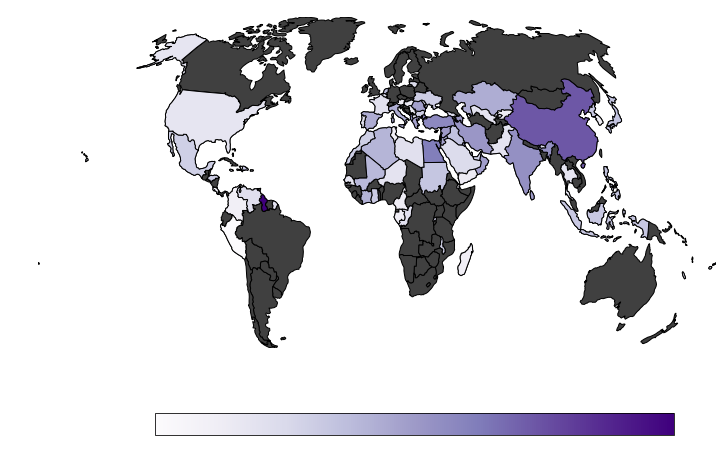

In [2]:
def geo_plot(df):
    colours = "Purples"
    
    # Get country data, exclude Antarctica, and re-project to Winkel-Tripel
    gdf = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
    gdf = gdf[(gdf.name != "Antarctica") & (gdf.name != "Fr. S. Antarctic Lands")]
    gdf = gdf.to_crs('+proj=wintri')

    merged = gdf.merge(df, left_on="iso_a3", right_on="country_code")

    # Plot the base map with the overlaid choropleth
    base = gdf.plot(color="0.25", edgecolor="black")
    merged.plot(ax=base, column="APC", edgecolor="black", cmap=colours, norm=colors.PowerNorm(gamma=0.33))

    # Format the resulting figure
    fig = plt.gcf()
    ax = plt.gca()
    ax.grid(False)
    ax.set_axis_off()
    ax.margins(0)
    
    # add colorbar axes to the figure
    # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
    cbax = fig.add_axes([0.32, 0.3, 0.45, 0.03])   
    cbax.set_title(r"Aubergines produced, per capita (shading normalised by $\sqrt[3]{x}$)", fontsize=16, color="white", pad=12)
    sm = plt.cm.ScalarMappable(cmap=colours, norm=colors.PowerNorm(gamma=0.33, vmin=min(merged["APC"]), vmax=max(merged["APC"])))
    
    # blank-out the array of the scalar mappable 'sm'
    sm._A = []
    # draw colorbar into 'cbax'
    ymin = min(merged["APC"])
    ymax = max(merged["APC"])
    yticks = np.round(np.power(np.linspace(np.cbrt(ymin), np.cbrt(ymax), 6), 3), 1)
    #yticks = ([int(num) if num > 0 and int(num) != 0 else num for num in yticks])
    cbar = fig.colorbar(sm, cax=cbax, ticks=yticks, format="%d", orientation="horizontal")
    cbar.ax.set_yticklabels(yticks)
    cbar.ax.tick_params(color="white", labelcolor="white")
    
    fig.set_size_inches(16, 10)
    plt.subplots_adjust(bottom=0.42)
    
    return base
    

geo_plot(df)

plt.rcParams['savefig.facecolor'] = '#141414'
plt.savefig("aubergines.png", bbox_inches="tight", dpi=200)